## SETUP

In [94]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile
import pandas as pd

import imageio
from tensorflow_docs.vis import embed

## PARAMETERS

In [2]:
image_size = 256
generator_input = int(image_size/8)
batch_size = 8

## IMPORT

In [4]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "images_proc", label_mode=None, image_size=(image_size, image_size), batch_size=batch_size, crop_to_aspect_ratio=True
)
dataset = dataset.map(lambda x: x / 255.0)

Found 9132 files belonging to 1 classes.


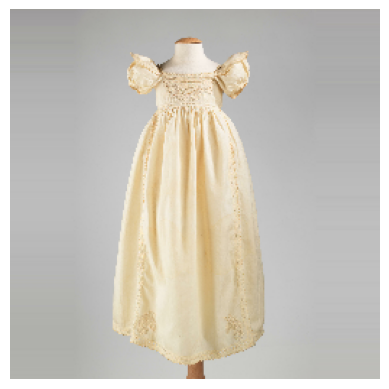

In [7]:
# display one image
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## DISCRIMINATOR

In [8]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(image_size, image_size, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 flatten (Flatten)           (None, 131072)          

## GENERATOR

In [9]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(generator_input * generator_input * 128),
        layers.Reshape((generator_input, generator_input, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 131072)            16908288  
                                                                 
 reshape (Reshape)           (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 256)    524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 128, 256)     0 

## GAN

In [10]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## GAN monitor

In [11]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("BasicGAN_gen/9000img/1/generated_img_%03d_%d.png" % (epoch, i))

## FIT

In [12]:
learning_rate = 0.0001

In [13]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
# gan.compile(
#     d_optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
#     g_optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
#     loss_fn=keras.losses.BinaryCrossentropy(),
# )

In [66]:
epochs = 80  # In practice, use ~100 epochs

In [ ]:
# load_status = gan.load_weights('BasicGAN_gen/8/GAN_8.ckpt')
# load_status.assert_consumed()

In [67]:
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim)]
)

Epoch 1/80
1142/1142 [==============================] - 312s 273ms/step - d_loss: 0.4758 - g_loss: 1.7328
Epoch 2/80
1142/1142 [==============================] - 331s 290ms/step - d_loss: 0.4704 - g_loss: 1.7451
Epoch 3/80
1142/1142 [==============================] - 327s 286ms/step - d_loss: 0.4572 - g_loss: 1.6066
Epoch 4/80
1142/1142 [==============================] - 343s 300ms/step - d_loss: 0.4609 - g_loss: 1.6430
Epoch 5/80
1142/1142 [==============================] - 342s 300ms/step - d_loss: 0.4636 - g_loss: 1.6705
Epoch 6/80
1142/1142 [==============================] - 336s 294ms/step - d_loss: 0.4577 - g_loss: 1.6728
Epoch 7/80
1142/1142 [==============================] - 329s 288ms/step - d_loss: 0.4521 - g_loss: 1.7355
Epoch 8/80
1142/1142 [==============================] - 343s 301ms/step - d_loss: 0.4614 - g_loss: 1.7626
Epoch 9/80
1142/1142 [==============================] - 328s 287ms/step - d_loss: 0.4504 - g_loss: 1.6512
Epoch 10/80
1142/1142 [=======================

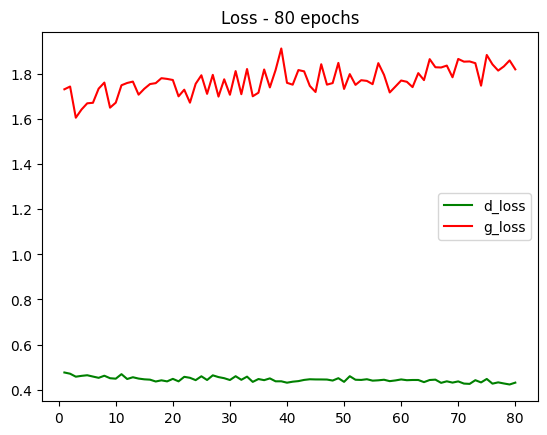

In [68]:
d_loss = gan.history.history['d_loss']
g_loss = gan.history.history['g_loss']
epch = range(1,len(d_loss)+1)
plt.plot(epch, d_loss,'g', label='d_loss')
plt.plot(epch, g_loss,'r', label='g_loss')
plt.title(f"Loss - {epochs} epochs")
plt.legend();

In [43]:
# initiate a dataframe to hold dloss and gloss
# dg_df = pd.DataFrame(columns=['d_loss','g_loss'])

In [69]:
dg_list = list(zip(d_loss,g_loss))
dg_df_new = pd.DataFrame(dg_list,columns=['d_loss','g_loss'])
dg_df = pd.concat([dg_df,dg_df_new],axis=0)

<AxesSubplot: >

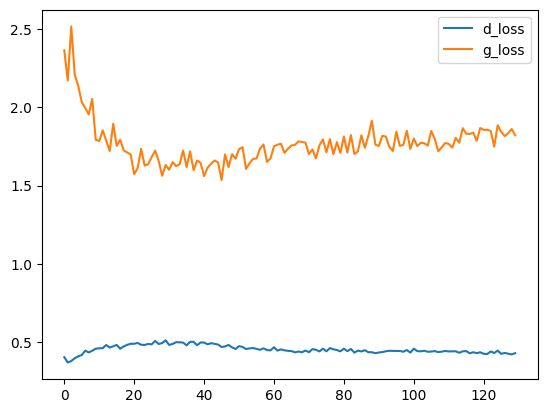

In [82]:
dg_df.reset_index(drop=True).plot()

In [71]:
dg_df.to_csv('BasicGAN_gen/9000img/1/dgloss.csv',index=False)

## SAVE THE WEIGHTS

In [72]:
gan.save_weights(filepath='BasicGAN_gen/9000img/1/GAN_9000_1_150.ckpt')

## generate


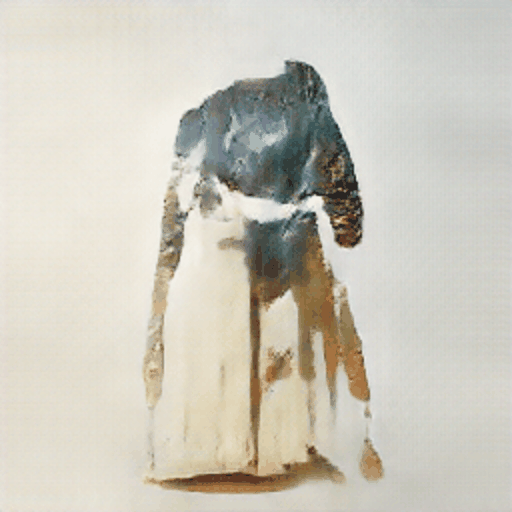

In [175]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 1  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))
noise_and_labels = tf.concat([interpolation_noise], 1)
fake = trained_gen.predict(noise_and_labels)

counter = 13
file_dir = 'BasicGAN_gen/9000img/6.1 basic gan/input 256/'
file_name = f"result {counter}.gif"
filepath = file_dir + file_name

fake *= 255.0
converted_images = fake.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (512, 512)).numpy().astype(np.uint8)
imageio.mimsave(filepath, converted_images, fps=0.5)
embed.embed_file(filepath)